In [1]:
from chaotic_inventory_opt.control.classical import sSPolicy, BaseStockPolicy
from chaotic_inventory_opt.control.fcio import FCIOPolicy
from chaotic_inventory_opt.control.network import NetworkFCIOPolicy

from chaotic_inventory_opt.core.inventory_system import InventorySystem
from chaotic_inventory_opt.core.cost import CostModel
from chaotic_inventory_opt.evaluation.performance import PerformanceMetrics
from chaotic_inventory_opt.evaluation.stability import StabilityMetrics
from chaotic_inventory_opt.chaos.lyapunov import LyapunovExponentEstimator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
cost_model = CostModel(
    holding_cost_per_unit=0.1,
    stockout_cost_per_unit=5.0,
    fixed_order_cost=1.0
)


In [3]:
def load_m5_multi_sku(item_ids, store_id):
    sales = pd.read_csv("sales_train_validation.csv")
    demand = {}

    for item_id in item_ids:
        row = sales[
            (sales["item_id"] == item_id) &
            (sales["store_id"] == store_id)
        ]

        d_cols = [c for c in row.columns if c.startswith("d_")]
        demand[item_id] = row[d_cols].values.flatten().astype(float)

    return demand


sku_list = [
    "FOODS_3_090",
    "FOODS_2_279",
    "FOODS_3_092",
    "FOODS_3_690",
    "FOODS_1_011"

]

demand_dict = load_m5_multi_sku(sku_list, "CA_1")

T = len(next(iter(demand_dict.values())))
print("Timesteps:", T)


Timesteps: 1913


In [4]:
def simulate_network(policy, demand_dict):
    systems = {sku: InventorySystem(initial_inventory=30) for sku in demand_dict}
    perf = PerformanceMetrics()
    stab = StabilityMetrics(LyapunovExponentEstimator())

    T = len(next(iter(demand_dict.values())))

    for t in range(T):
        demand_t = {sku: demand_dict[sku][t] for sku in demand_dict}

        if hasattr(policy, "observe"):
            policy.observe(demand_t)

        inventory_t = {sku: systems[sku].I for sku in systems}
        orders = policy.order(inventory_t)

        for sku in systems:
            inv = systems[sku].step(demand_t[sku], orders[sku])
            cost = cost_model.compute(inv, orders[sku])

            perf.update(demand_t[sku], inv, cost)
            stab.update(inv)

    return perf.results(), stab.results()


In [5]:
ssp_policies = {sku: sSPolicy(10, 30) for sku in sku_list}
bs_policies  = {sku: BaseStockPolicy(30) for sku in sku_list}

results_ssp_net, stab_ssp_net = simulate_network(
    NetworkFCIOPolicy(ssp_policies), demand_dict
)

results_bs_net, stab_bs_net = simulate_network(
    NetworkFCIOPolicy(bs_policies), demand_dict
)

print("Network (s,S):", results_ssp_net, stab_ssp_net)
print("Network Base Stock:", results_bs_net, stab_bs_net)


Network (s,S): {'total_cost': 441818.7000000032, 'service_level': 0.37545554205801307, 'stockout_events': 1398} {'inventory_variance': 562.9903999999999, 'lyapunov_exponent': 2.72178181815912}
Network Base Stock: {'total_cost': 448837.40000000875, 'service_level': 0.3763295902343634, 'stockout_events': 1396} {'inventory_variance': 650.1583999999999, 'lyapunov_exponent': 0.3350017724311479}


In [6]:
import optuna

c:\Users\SANTANU\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def network_fcio_objective(trial):
    params = dict(
        alpha=trial.suggest_float("alpha", 0.1, 1.5),
        beta=trial.suggest_float("beta", 0.1, 1.5),
        scale_min=trial.suggest_float("scale_min", 0.5, 0.9),
        scale_max=trial.suggest_float("scale_max", 1.1, 1.6),
        rho=trial.suggest_float("rho", 0.4, 0.8),
        gamma=trial.suggest_float("gamma", 1.0, 2.0),
        k_cap=trial.suggest_float("k_cap", 0.4, 1.0),
    )

    policies = {
        sku: FCIOPolicy(
            base_stock_level=30,
            reorder_point=10,
            window=100,
            **params,
        )
        for sku in sku_list
    }

    network_policy = NetworkFCIOPolicy(policies)

    results, _ = simulate_network(network_policy, demand_dict)

    score = (
        results["total_cost"]
        + 5_000 * results["stockout_events"]
        + 100_000 * max(0, 0.95 - results["service_level"])
    )

    return score


In [8]:
study = optuna.create_study(direction="minimize")
study.optimize(network_fcio_objective, n_trials=100)

print("Best network score:", study.best_value)
print("Best network params:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")


[I 2026-01-02 22:48:32,573] A new study created in memory with name: no-name-27f16350-cac4-4db1-94dc-ad37ef57aa25
[I 2026-01-02 22:48:37,135] Trial 0 finished with value: 2999422.772048452 and parameters: {'alpha': 1.3398310231162167, 'beta': 1.2852933081574929, 'scale_min': 0.5583792598171953, 'scale_max': 1.5277013041868752, 'rho': 0.4414214970288479, 'gamma': 1.8594800069220099, 'k_cap': 0.7605408012072776}. Best is trial 0 with value: 2999422.772048452.
[I 2026-01-02 22:48:41,197] Trial 1 finished with value: 7647532.562049027 and parameters: {'alpha': 0.9365942704158386, 'beta': 0.24638486334946577, 'scale_min': 0.7228656846459433, 'scale_max': 1.2796071666941415, 'rho': 0.6630257305530695, 'gamma': 1.136145892083667, 'k_cap': 0.7969482928641676}. Best is trial 0 with value: 2999422.772048452.
[I 2026-01-02 22:48:45,683] Trial 2 finished with value: 5029985.595543752 and parameters: {'alpha': 1.343207961400209, 'beta': 0.7825570054595388, 'scale_min': 0.584852751710657, 'scale_max

Best network score: 1336436.8139004393
Best network params:
alpha: 1.1764292851060452
beta: 0.3693837326615798
scale_min: 0.7143992335395265
scale_max: 1.5996151905817075
rho: 0.7833486078340347
gamma: 1.9142524652996808
k_cap: 0.7451422791807618


In [9]:
best = study.best_params

fcio_policies = {
    sku: FCIOPolicy(
        base_stock_level=30,
        reorder_point=10,
        window=100,
        **best,
    )
    for sku in sku_list
}

network_fcio = NetworkFCIOPolicy(fcio_policies)

results_fcio_net, stab_fcio_net = simulate_network(
    network_fcio, demand_dict
)

print("Network FCIO:", results_fcio_net, stab_fcio_net)


Network FCIO: {'total_cost': 66436.81390043937, 'service_level': 0.9841022590942036, 'stockout_events': 254} {'inventory_variance': 182.23603284381232, 'lyapunov_exponent': 2.364051866731253}


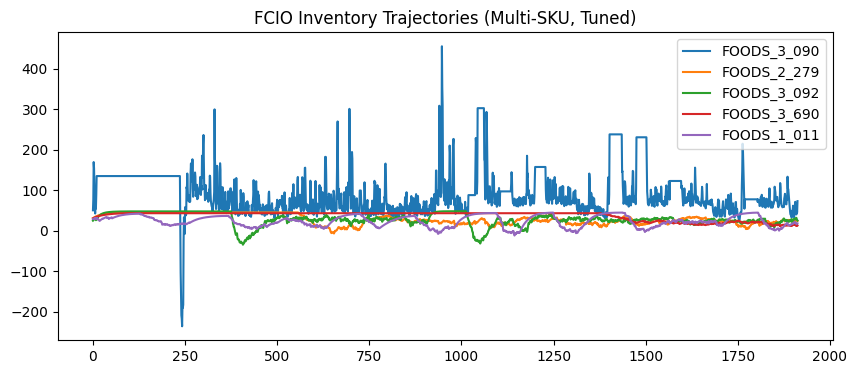

In [10]:
plt.figure(figsize=(10,4))

for sku in sku_list:
    system = InventorySystem(30)
    inv_hist = []

    for t in range(T):
        fcio_policies[sku].observe(demand_dict[sku][t])
        inv_hist.append(system.step(
            demand_dict[sku][t],
            fcio_policies[sku].order(system.I)
        ))

    plt.plot(inv_hist, label=sku)

plt.legend()
plt.title("FCIO Inventory Trajectories (Multi-SKU, Tuned)")
plt.show()
